In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import tensorflow_probability as tfp
import tensorflow.keras.backend as K

In [3]:
def split_data(df, choose):
  if choose == 1: # 7:2:1
    train_size = int(len(df) * 0.7)
    test_size = int(len(df) * 0.2)
    val_size = len(df) - train_size - test_size

    train_data = df[:train_size]
    test_data = df[train_size:train_size + test_size]
    val_data = df[train_size + test_size:]

  elif choose == 2: # 5:3:2
    train_size = int(len(df) * 0.5)
    test_size = int(len(df) * 0.3)
    val_size = len(df) - train_size - test_size

    train_data = df[:train_size]
    test_data = df[train_size:train_size + test_size]
    val_data = df[train_size + test_size:]

  elif choose == 3: # 6:2:2
    train_size = int(len(df) * 0.6)
    test_size = int(len(df) * 0.2)
    val_size = len(df) - train_size - test_size

    train_data = df[:train_size]
    test_data = df[train_size:train_size + test_size]
    val_data = df[train_size + test_size:]


  print("Train: ", train_size)
  print("Test: ", test_size)
  print("Val: ", val_size)

  return train_data, test_data, val_data

In [4]:
# load the dataset
df = pd.read_csv('/content/drive/MyDrive/Project/dataset/NFLX_Stock.csv',usecols=['Date', 'Price'])#, parse_dates=['Date'], index_col='Date')
df.head()

,Date,Price
0,12/01/2017,186.82
1,12/04/2017,184.04
2,12/05/2017,184.21
3,12/06/2017,185.30
4,12/07/2017,185.20


In [5]:
train_data, test_data, val_data = split_data(df , 1)

Train:  974
Test:  278
Val:  140


In [6]:
def create_dataset(df, lookback):
    data = np.array(df['Price'])

    X = []
    y = []
    for i in range(lookback, len(data)):
        X.append(data[i - lookback:i])
        y.append(data[i])
    X = np.array(X)
    y = np.array(y)
    return X, y

lookback = 10
X_train, y_train = create_dataset(train_data, lookback)
X_val, y_val = create_dataset(val_data, lookback)
X_test, y_test = create_dataset(test_data, lookback)

In [7]:
# Bayesian Neural Network

input_shape = (lookback,)

model = Sequential()
model.add(InputLayer(input_shape=input_shape))
model.add(tfp.layers.DenseFlipout(32, activation='LeakyReLU'))
model.add(tfp.layers.DenseFlipout(1))

model.summary()

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_flipout (DenseFlipout  (None, 32)               672       
 )                                                               
                                                                 
 dense_flipout_1 (DenseFlipo  (None, 1)                65        
 ut)                                                             
                                                                 
Total params: 737
Trainable params: 737
Non-trainable params: 0
_________________________________________________________________


In [8]:

model.compile(loss='mean_squared_error', optimizer=tf.optimizers.Adam(learning_rate=0.001))#, metrics=[MeanAbsolutePercentageError()])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32)

Epoch 1/100
31/31 [==============================] - 7s 18ms/step - loss: 73251.7891 - val_loss: 13211.9541
Epoch 2/100
31/31 [==============================] - 0s 7ms/step - loss: 5978.8325 - val_loss: 4965.8027
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 3924.4006 - val_loss: 5267.2749
Epoch 4/100
31/31 [==============================] - 0s 8ms/step - loss: 3853.1941 - val_loss: 4268.6553
Epoch 5/100
31/31 [==============================] - 0s 8ms/step - loss: 3786.8650 - val_loss: 4352.1577
Epoch 6/100
31/31 [==============================] - 0s 6ms/step - loss: 3761.9192 - val_loss: 3948.0723
Epoch 7/100
31/31 [==============================] - 0s 8ms/step - loss: 3664.5107 - val_loss: 3695.9268
Epoch 8/100
31/31 [==============================] - 0s 6ms/step - loss: 3491.9924 - val_loss: 3911.0247
Epoch 9/100
31/31 [==============================] - 0s 6ms/step - loss: 3369.0051 - val_loss: 4251.3662
Epoch 10/100
31/31 [==============================] 

In [9]:
# evaluate trên tập test
loss = model.evaluate(X_test, y_test, verbose=0)
print("Loss test: ", loss)

# evaluate trên tập val
loss = model.evaluate(X_val, y_val, verbose=0)
print("Loss validation: ", loss)

Loss test:  1858.85546875
Loss validation:  1386.2197265625


In [10]:
def mae_rmse_mape(true, predict):
  mae = mean_absolute_error(true, predict)
  rmse = np.sqrt(mean_squared_error(true, predict))
  mape = mean_absolute_percentage_error(true, predict)

  return mae, rmse, mape

In [11]:
mae_val, rmse_val, mape_val = mae_rmse_mape(y_val, model.predict(X_val))
print("MAE of Validation: ", mae_val)
print("RMSE of Validation: ", rmse_val)
print("MAPE of Validation: ", mape_val)

mae_test, rmse_test, mape_test = mae_rmse_mape(y_test, model.predict(X_test))
print("MAE of Test: ", mae_test)
print("RMSE of Test: ", rmse_test)
print("MAPE of Test: ", mape_test)

5/5 [==============================] - 0s 4ms/step
MAE of Validation:  14.395184889573319
RMSE of Validation:  18.07639594938623
MAPE of Validation:  0.042939346484817106
9/9 [==============================] - 0s 3ms/step
MAE of Test:  21.277721036085442
RMSE of Test:  31.07569482110333
MAPE of Test:  0.06589248154622414


In [12]:
NUM_SAMPLES = len(X_val)

# dự đoán for X_val
y_pred = np.zeros((NUM_SAMPLES, len(X_val)))
for i in range(NUM_SAMPLES):
    y_pred[i] = model.predict(X_val).flatten()

# Tính mean and standard deviation của predictions
y_mean = np.mean(y_pred, axis=0)
y_std = np.std(y_pred, axis=0)

5/5 [==============================] - 0s 3ms/step


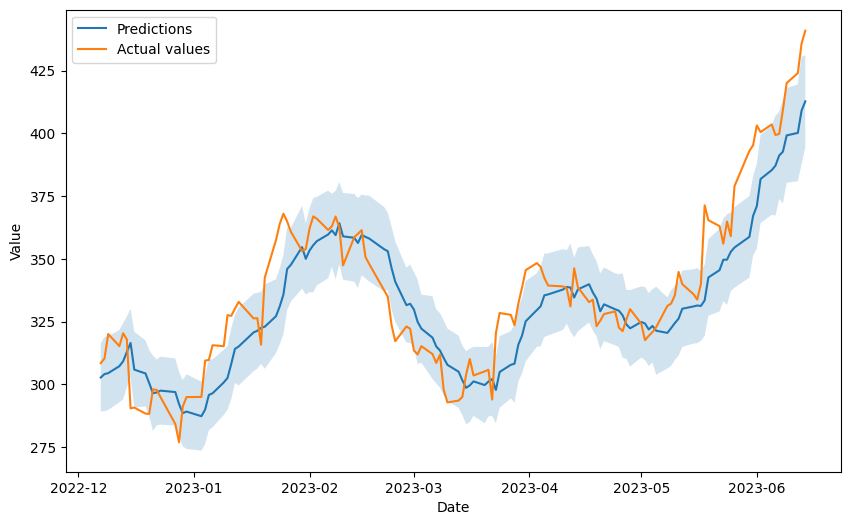

In [13]:
# Chuyển date strings sang datetime objects
dates = pd.to_datetime(val_data['Date'][lookback:])

# Biểu diễn
plt.figure(figsize=(10, 6))
plt.plot(dates, y_mean, label='Predictions')
plt.fill_between(dates, y_mean - y_std, y_mean + y_std, alpha=0.2) #khoảng có khả năng y_pred có thể đạt được
plt.plot(dates, y_val, label='Actual values')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

In [14]:
y_pred_test = np.zeros((len(X_test), len(X_test)))
for i in range(len(X_test)):
    y_pred_test[i] = model.predict(X_test).flatten()

y_pred_val = np.zeros((len(X_val), len(X_val)))
for i in range(len(X_val)):
    y_pred_val[i] = model.predict(X_val).flatten()

y_mean_test = np.mean(y_pred_test, axis=0)
y_std_test = np.std(y_pred_test, axis=0)

y_mean_val = np.mean(y_pred_val, axis=0)
y_std_val = np.std(y_pred_val, axis=0)

5/5 [==============================] - 0s 3ms/step


In [15]:
dates_train = pd.to_datetime(train_data['Date'][lookback:])
dates_val = pd.to_datetime(val_data['Date'][lookback:])
dates_test = pd.to_datetime(test_data['Date'][lookback:])

In [16]:
future_dates = pd.date_range(start=dates_val.iloc[-1], periods=30, closed='right')
future_inputs = X_val[:30]
#future_inputs = np.zeros((30, lookback))

# Generate predictions for the next 30 days
future_predictions = np.zeros((NUM_SAMPLES, 30))
for i in range(NUM_SAMPLES):
    future_predictions[i] = model.predict(future_inputs).flatten()

# Compute mean and standard deviation of future predictions
future_mean = np.mean(future_predictions, axis=0)
future_std = np.std(future_predictions, axis=0)

# Plot predictions for the next 30 days
future_dates_all = pd.date_range(start=dates_val.iloc[-1], periods=31, closed='right')

1/1 [==============================] - 0s 18ms/step


<ipython-input-16-2b15b5682e6d>:1: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(start=dates_val.iloc[-1], periods=30, closed='right')


1/1 [==============================] - 0s 31ms/step


<ipython-input-16-2b15b5682e6d>:15: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates_all = pd.date_range(start=dates_val.iloc[-1], periods=31, closed='right')


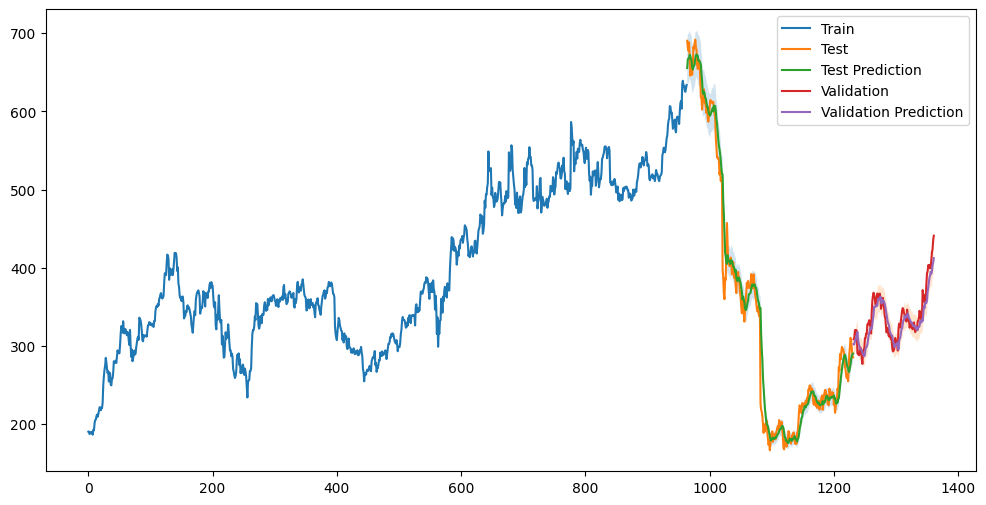

In [17]:
plt.figure(figsize=(12,6))

plt.plot(y_train, label='Train')

plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, label='Test')
plt.plot(range(len(y_train), len(y_train) + len(y_test)),  y_mean_test.reshape(-1, 1), label='Test Prediction')
plt.fill_between(range(len(y_train), len(y_train) + len(y_test)), y_mean_test - y_std_test, y_mean_test + y_std_test, alpha=0.2) #khoảng có khả năng y_pred có thể đạt được

plt.plot(range(len(y_train) + len(y_test), len(y_train) + len(y_test) + len(y_val)), y_val, label='Validation')
plt.plot(range(len(y_train) + len(y_test), len(y_train) + len(y_test) + len(y_val)), y_mean_val.reshape(-1, 1), label='Validation Prediction')
plt.fill_between(range(len(y_train) + len(y_test), len(y_train) + len(y_test) + len(y_val)), y_mean_val - y_std_val, y_mean_val + y_std_val, alpha=0.2) #khoảng có khả năng y_pred có thể đạt được

#plt.plot(range(len(y_train) + len(y_test) + len(y_val), len(y_train) + len(y_test) + len(y_val) + 30), future_mean.reshape(-1, 1), label='30days_Next')

plt.legend()
plt.show()

In [18]:
# Vẽ theo ngày

# plt.figure(figsize=(12, 8))
# plt.plot(dates_train, y_train, label='Train')
# plt.plot(dates_test, y_test, label='Test')
# plt.plot(dates_test, y_mean_test.reshape(-1, 1), label='Predicted Test')
# plt.fill_between(dates_test, y_mean_test - y_std_test, y_mean_test + y_std_test, alpha=0.2) #khoảng có khả năng y_pred có thể đạt được

# plt.plot(dates_val, y_val, label='Validation')
# plt.plot(dates_val, y_mean_val.reshape(-1, 1), label='Predicted Validation')
# plt.fill_between(dates_val, y_mean_val - y_std_val, y_mean_val + y_std_val, alpha=0.2) #khoảng có khả năng y_pred có thể đạt được

# plt.plot(future_dates_all, future_mean.reshape(-1, 1), label='30 days')

# plt.xlabel('Date')
# plt.ylabel('Value')
# plt.legend()
# plt.title('Actual and Predicted Values')
# plt.show()

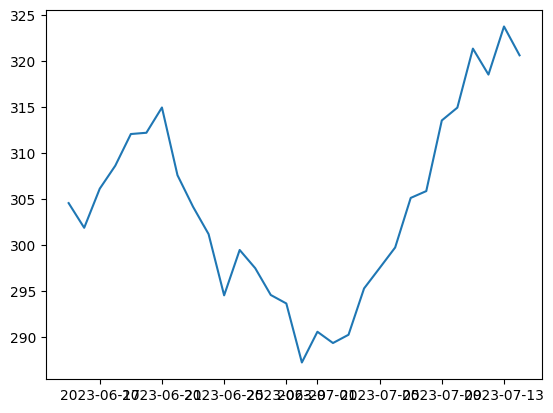

In [19]:
plt.plot(future_dates_all, future_mean.reshape(-1, 1), label='Validation')

#### Tuning hyperparameters

In [20]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [21]:
def build_bnn_model(activation):
    model = Sequential()
    model.add(InputLayer(input_shape=input_shape))
    model.add(tfp.layers.DenseFlipout(32, activation=activation))
    model.add(tfp.layers.DenseFlipout(1))
    model.compile(loss='mean_squared_error', optimizer=tf.optimizers.Adam(learning_rate=0.001))
    return model

In [22]:
bnn_model = KerasRegressor(build_fn=build_bnn_model, verbose=0)
param_grid = {'activation': ['relu', 'tanh', 'sigmoid', 'LeakyReLU']}

grid = GridSearchCV(estimator=bnn_model, param_grid=param_grid, cv=3, error_score='raise')
grid_result = grid.fit(X_train, y_train)

best_activation = grid_result.best_params_['activation']
print(f'Best activation: {best_activation}')

<ipython-input-22-4888ad3085d7>:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  bnn_model = KerasRegressor(build_fn=build_bnn_model, verbose=0)
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


Best activation: LeakyReLU


In [23]:
model_best = build_bnn_model(best_activation)
history = model_best.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32)

Epoch 1/100
31/31 [==============================] - 2s 16ms/step - loss: 58924.2305 - val_loss: 6857.6519
Epoch 2/100
31/31 [==============================] - 0s 6ms/step - loss: 5038.7476 - val_loss: 4953.3867
Epoch 3/100
31/31 [==============================] - 0s 7ms/step - loss: 4274.8828 - val_loss: 4847.0918
Epoch 4/100
31/31 [==============================] - 0s 6ms/step - loss: 4274.5791 - val_loss: 3930.3877
Epoch 5/100
31/31 [==============================] - 0s 7ms/step - loss: 3811.9907 - val_loss: 4310.2075
Epoch 6/100
31/31 [==============================] - 0s 8ms/step - loss: 3984.8418 - val_loss: 4429.4185
Epoch 7/100
31/31 [==============================] - 0s 7ms/step - loss: 4439.3574 - val_loss: 3994.2751
Epoch 8/100
31/31 [==============================] - 0s 6ms/step - loss: 3507.0090 - val_loss: 4694.3652
Epoch 9/100
31/31 [==============================] - 0s 6ms/step - loss: 3858.1218 - val_loss: 3363.3479
Epoch 10/100
31/31 [==============================] -

In [24]:
# evaluate trên tập test
loss = model_best.evaluate(X_test, y_test, verbose=0)
print("Loss test: ", loss)

# evaluate trên tập val
loss = model_best.evaluate(X_val, y_val, verbose=0)
print("Loss validation: ", loss)

Loss test:  2139.200439453125
Loss validation:  1370.861328125


In [25]:
mae_val, rmse_val, mape_val = mae_rmse_mape(y_val, model_best.predict(X_val))
print("MAE of Validation: ", mae_val)
print("RMSE of Validation: ", rmse_val)
print("MAPE of Validation: ", mape_val)

mae_test, rmse_test, mape_test = mae_rmse_mape(y_test, model_best.predict(X_test))
print("MAE of Test: ", mae_test)
print("RMSE of Test: ", rmse_test)
print("MAPE of Test: ", mape_test)

5/5 [==============================] - 0s 3ms/step
MAE of Validation:  17.97203013258714
RMSE of Validation:  21.899294725017025
MAPE of Validation:  0.05370672597986548
9/9 [==============================] - 0s 3ms/step
MAE of Test:  24.500550263817633
RMSE of Test:  34.203641567182956
MAPE of Test:  0.07761074679243554


In [26]:
NUM_SAMPLES = len(X_val)

# dự đoán for X_val
y_pred = np.zeros((NUM_SAMPLES, len(X_val)))
for i in range(NUM_SAMPLES):
    y_pred[i] = model_best.predict(X_val).flatten()

# Tính mean and standard deviation của predictions
y_mean = np.mean(y_pred, axis=0)
y_std = np.std(y_pred, axis=0)

5/5 [==============================] - 0s 3ms/step


In [27]:
y_pred_test = np.zeros((len(X_test), len(X_test)))
for i in range(len(X_test)):
    y_pred_test[i] = model_best.predict(X_test).flatten()

y_pred_val = np.zeros((len(X_val), len(X_val)))
for i in range(len(X_val)):
    y_pred_val[i] = model_best.predict(X_val).flatten()

y_mean_test = np.mean(y_pred_test, axis=0)
y_std_test = np.std(y_pred_test, axis=0)

y_mean_val = np.mean(y_pred_val, axis=0)
y_std_val = np.std(y_pred_val, axis=0)

5/5 [==============================] - 0s 3ms/step


In [28]:
future_dates = pd.date_range(start=dates_val.iloc[-1], periods=30, closed='right')
future_inputs = X_val[:30]
#future_inputs = np.zeros((30, lookback))

# Generate predictions for the next 30 days
future_predictions = np.zeros((NUM_SAMPLES, 30))
for i in range(NUM_SAMPLES):
    future_predictions[i] = model_best.predict(future_inputs).flatten()

# Compute mean and standard deviation of future predictions
future_mean = np.mean(future_predictions, axis=0)
future_std = np.std(future_predictions, axis=0)

# Plot predictions for the next 30 days
future_dates_all = pd.date_range(start=dates_val.iloc[-1], periods=31, closed='right')

1/1 [==============================] - 0s 19ms/step


<ipython-input-28-14cd249fc154>:1: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(start=dates_val.iloc[-1], periods=30, closed='right')


1/1 [==============================] - 0s 21ms/step


<ipython-input-28-14cd249fc154>:15: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates_all = pd.date_range(start=dates_val.iloc[-1], periods=31, closed='right')


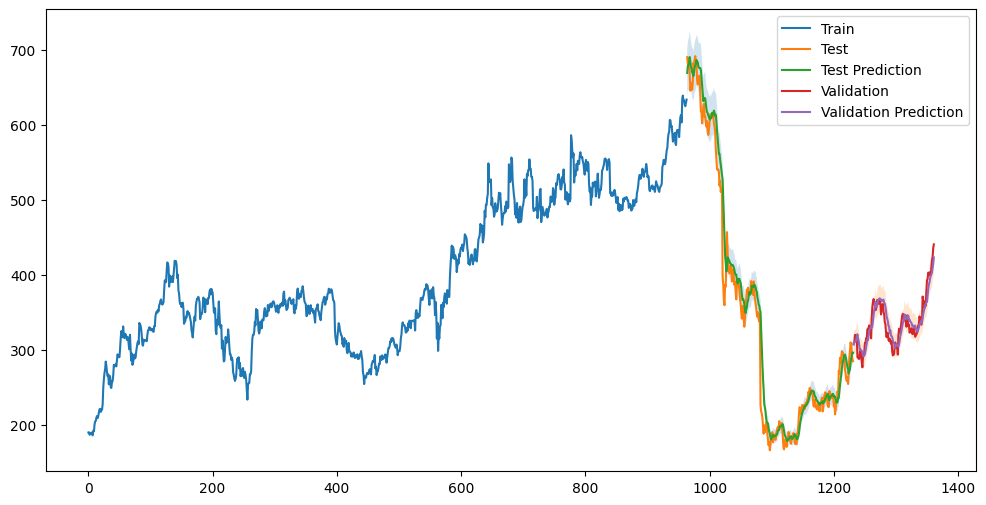

In [29]:
plt.figure(figsize=(12,6))

plt.plot(y_train, label='Train')

plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, label='Test')
plt.plot(range(len(y_train), len(y_train) + len(y_test)),  y_mean_test.reshape(-1, 1), label='Test Prediction')
plt.fill_between(range(len(y_train), len(y_train) + len(y_test)), y_mean_test - y_std_test, y_mean_test + y_std_test, alpha=0.2) #khoảng có khả năng y_pred có thể đạt được

plt.plot(range(len(y_train) + len(y_test), len(y_train) + len(y_test) + len(y_val)), y_val, label='Validation')
plt.plot(range(len(y_train) + len(y_test), len(y_train) + len(y_test) + len(y_val)), y_mean_val.reshape(-1, 1), label='Validation Prediction')
plt.fill_between(range(len(y_train) + len(y_test), len(y_train) + len(y_test) + len(y_val)), y_mean_val - y_std_val, y_mean_val + y_std_val, alpha=0.2) #khoảng có khả năng y_pred có thể đạt được

#plt.plot(range(len(y_train) + len(y_test) + len(y_val), len(y_train) + len(y_test) + len(y_val) + 30), future_mean.reshape(-1, 1), label='30days_Next')

plt.legend()
plt.show()

In [30]:


# plt.figure(figsize=(12, 8))
# plt.plot(dates_train, y_train, label='Train')
# plt.plot(dates_test, y_test, label='Test')
# plt.plot(dates_test, y_mean_test.reshape(-1, 1), label='Predicted Test')
# plt.fill_between(dates_test, y_mean_test - y_std_test, y_mean_test + y_std_test, alpha=0.2) #khoảng có khả năng y_pred có thể đạt được

# plt.plot(dates_val, y_val, label='Validation')
# plt.plot(dates_val, y_mean_val.reshape(-1, 1), label='Predicted Validation')
# plt.fill_between(dates_val, y_mean_val - y_std_val, y_mean_val + y_std_val, alpha=0.2) #khoảng có khả năng y_pred có thể đạt được

# plt.plot(future_dates_all, future_mean.reshape(-1, 1), label='30 days')

# plt.xlabel('Date')
# plt.ylabel('Value')
# plt.legend()
# plt.title('Actual and Predicted Values')
# plt.show()